# PDE-FIND za Van der Polov oscilator

Vinko Dragušica, 2022.

Predstavljen je kod koji pomoću modula PDE-FIND iz danih podataka otkriva jednadžbu koja opisuje dinamiku Van der Polovog oscilatora za $\mu=5$.
$$
u_{tt} - \mu(1-x^2)u_t + u = 0
$$

In [1]:
%matplotlib inline
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import sys; sys.path.append('../')
from PDE_FIND_CM import *

In [2]:
# u funkciju ubacujemo varijable i ona izbacuje derivacije tih varijabli
def model(z,t,mu=5):
    x = z[0]
    dx = z[1]
    ddx = mu*(1-x**2)*dx - x
    dzdt = [dx,ddx]
    return dzdt

# početni uvjet (z0 = [x(t=0), dx/dt(t=0)])
z0 = [0,-5]

# prostorne i vremenske točke
x = [0]
#dx = x[1]-x[0]
t = np.linspace(0,20,500)
dt = t[1]-t[0]

# rješavamo ODJ
z = odeint(model,z0,t)
u = np.array([z[:,0]])

Text(0, 0.5, 'u(t)')

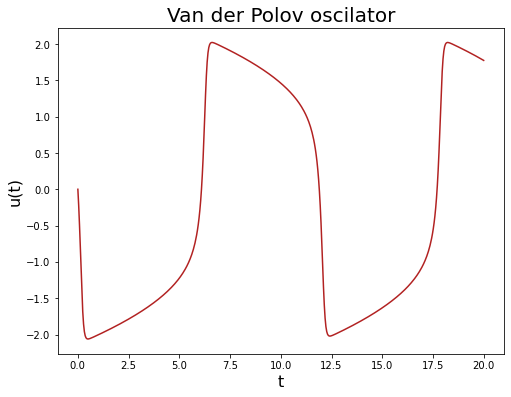

In [3]:
fig1 = plt.figure(figsize=(8,6))
plt.plot(t,u[0,:],color='firebrick')
plt.title('Van der Polov oscilator', fontsize = 20)
plt.xlabel('t', fontsize = 16)
plt.ylabel('u(t)', fontsize = 16)

## Konstruiramo $\Theta (U)$ i računamo $U_t$:

Konstruiramo funkcije koje će se nalaziti u $\Theta$. Također specificiramo njihove opise i na kraju pomoću build_Theta konstruiramo $\Theta$ koji ćemo koristiti kasnije. <br>
time_diff i space_diff izračunati su pomoću metode konačnih razlika (funkcija FiniteDiff()).

Ispisana je lista funkcija kandidata za PDJ. Svaka od ispisanih funkcija ekvivalentna je stupcu u $\Theta (U)$.

In [4]:
m = len(x)
n = len(t)

ut = np.zeros((m,n), dtype=np.complex64)
utt = np.zeros((m,n), dtype=np.complex64)

for i in range(m):
    ut[i,:] = FiniteDiff(u[i,:], dt, 1)
    utt[i,:] = FiniteDiff(u[i,:], dt,2) # koristi se kasnije kod funkcije TrainSTRidge

ut = np.reshape(ut, (n*m,1), order='F')
utt = np.reshape(utt, (n*m,1), order='F')

X_ders = np.hstack([np.ones((n*m,1)),ut])
X_data = np.hstack([np.reshape(u, (n*m,1), order='F')])
derivatives_description = ['','u_t']

X, descr = build_Theta(X_data, X_ders, derivatives_description, P=2, data_description = ['u'])
descr

['', 'u_t', 'u', 'u^2', 'uu_t', 'u^2u_t']

## Računamo $\xi$:

TrainSTRidge dijeli podatke na dio za trening (80% ukupnih podataka) i dio za validaciju (20% ukupnih podataka). Algoritam traži optimalnu vrijednost za varijablu tol (tolerancija ispod koje zanemarujemo varijablu) i odabire toleranciju provjerom na validacijskom skupu, uključujući i $\ell^0$ penalizaciju za $\xi$ u funkciji gubitka.

In [5]:
# Solve with STRidge
w = TrainSTRidge(X,utt,10**-5,0.1)
print("PDJ dobivena pomoću STRidge:")
print_pde(w, descr)

PDJ dobivena pomoću STRidge:
u_tt = (4.926123 +0.000000i)u_t
    + (-0.976853 +0.000000i)u
    + (-4.905555 +0.000000i)u^2u_t
   


In [6]:
err = abs(np.array([(5 -  4.926123)/5*100,(1 - 0.976853)*100,(5 - 4.905555)/5*100]))
print("Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima:\n")
print("Srednja greška parametara:", np.mean(err), '%')
print("Standardna devijacija srednje greške parametara:", np.std(err), '%')

Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima:

Srednja greška parametara: 1.8937133333333394 %
Standardna devijacija srednje greške parametara: 0.3417860856669769 %


Jednadžba $u_{tt} = 5 u_t - u - 5 x^2 u_t$ je dosta dobro rekonstruirana, ali tek nakon što je broj točaka u danom vremenskom intervalu $[0,50]$ povećan na N=500.

## Identificiramo istu dinamiku ali sa dodanim šumom na podatcima:

Jedina razlika od primjera gore je da metoda konačnih razlika ne radi dobro za podatke sa šumom pa koristimo polinomijalnu interpolaciju. Sa deg_x ili deg_t i width_x i width_t određujemo stupanj polinoma i broj točaka za deriviranje po x i t. Nažalost, rezultati mogu biti osjetljivi na ove veličine.

In [7]:
np.random.seed(0)
un = u + 0.03*np.std(u)*np.random.randn(u.shape[0],u.shape[1])

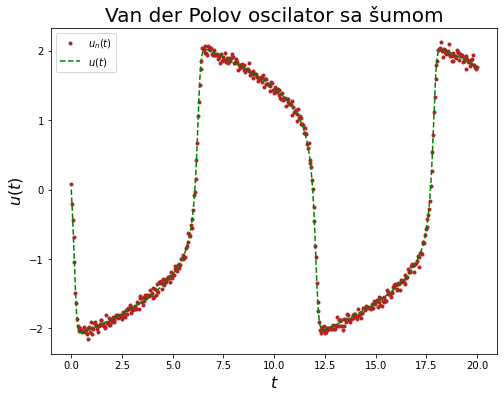

In [8]:
fig1 = plt.figure(figsize=(8,6))
plt.plot(t,un[0,:],'.',color='firebrick',label='$u_n(t)$')
plt.plot(t,u[0,:],'--',color='green',label='$u(t)$')
plt.title('Van der Polov oscilator sa šumom', fontsize = 20)
plt.xlabel('$t$', fontsize = 16)
plt.ylabel('$u(t)$', fontsize = 16)
plt.legend()

In [9]:
def trim(u, d): #funkcija koja treba kasnije kako bi algoritam funkcionirao
    ind = np.arange(0, len(u))
    u_trim = np.delete(u, np.concatenate((ind[:d],ind[-d:])))
    return u_trim

In [10]:
m = len(x)
n = len(t)

width = 3 # sirina prozora kod PolyDiff funkcije

unt = np.zeros((m,n-2*width), dtype=np.complex64)
untt = np.zeros((m,n-2*width), dtype=np.complex64)
ones = np.ones((m,n), dtype=np.complex64)

for i in range(m):
    unt[i,:] = PolyDiff(un[i,:], t, diff=2, width=width)[:,0]
    untt[i,:] = PolyDiff(un[i,:], t, diff=2, width=width)[:,1] # koristi se kasnije kod funkcije TrainSTRidge

un = trim(un[0,:], width)
ones = trim(ones[0,:], width)

unt = np.reshape(unt, (-1,1), order='F')
untt = np.reshape(untt, (-1,1), order='F')

X_ders = np.hstack([np.ones((n*m-2*width,1)), unt])
X_data = np.hstack([np.reshape(un, (-1,1), order='F')])
derivatives_description = ['','u_t']

X, descr = build_Theta(X_data, X_ders, derivatives_description, P=2, data_description = ['u'])
descr

['', 'u_t', 'u', 'u^2', 'uu_t', 'u^2u_t']

In [11]:
w = TrainSTRidge(X,untt,10**-5,0.1)
print("PDJ dobivena pomoću STRidge:")
print_pde(w, descr)

PDJ dobivena pomoću STRidge:
u_tt = (0.585740 +0.000000i)
    + (3.102668 +0.000000i)u_t
    + (-1.118619 +0.000000i)u
    + (-0.237092 +0.000000i)u^2
    + (0.166710 +0.000000i)uu_t
    + (-2.788609 +0.000000i)u^2u_t
   


In [12]:
err = abs(np.array([(5 - 3.102668)/5*100, (1 - 1.118619)*100, (5 - 2.788609)/5*100]))
print("Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima sa šumom:\n")
print("Srednja greška parametara:", np.mean(err), '%')
print("Standardna devijacija srednje greške parametara:", np.std(err), '%')

Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima sa šumom:

Srednja greška parametara: 31.345453333333328 %
Standardna devijacija srednje greške parametara: 14.01356351105916 %
